[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO11 Object Detection on a Custom Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Tue Oct  1 13:03:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [4]:
%pip install "ultralytics<=8.3.40" supervision roboflow
# prevent ultralytics from tracking your activity
!yolo settings sync=False
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 21.4/107.7 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [3]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

100% 5.35M/5.35M [00:00<00:00, 188MB/s]
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/cfg/__init__.py", line 972, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/engine/model.py", line 550, in predict
    self.predictor.setup_model(model=self.model, verbose=is_cli)
  File "/usr/local/lib/python3.12/dist-packages/ultralytics/engine/predictor.py", line 308, in setup_model
    self.model = AutoBackend(
                 ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/_contextlib.py", line 120, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.

**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

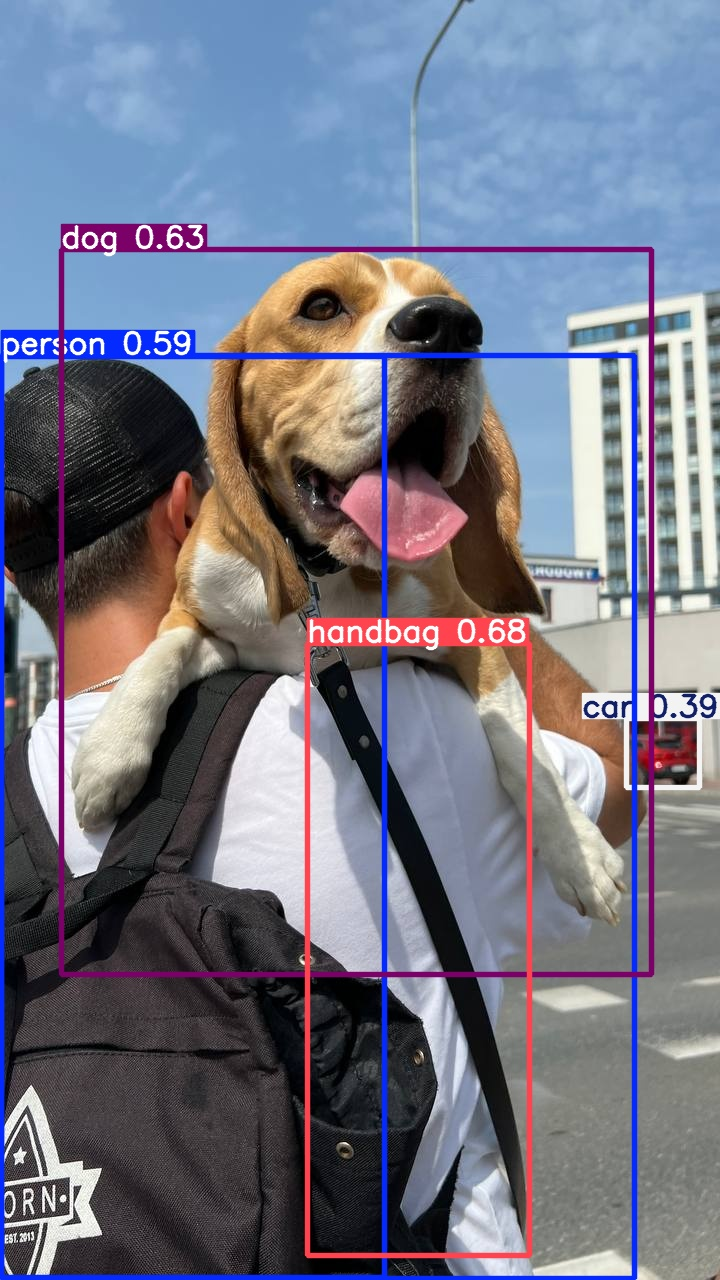

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/predict/dog.jpeg', width=600)

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [ ]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://media.roboflow.com/notebooks/examples/dog.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]


0: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 60.1ms
Speed: 3.9ms preprocess, 60.1ms inference, 924.2ms postprocess per image at shape (1, 3, 640, 384)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [ ]:
result.boxes.xyxy

tensor([[3.0705e+02, 6.4341e+02, 5.2919e+02, 1.2558e+03],
        [6.1400e+01, 2.4994e+02, 6.5165e+02, 9.7412e+02],
        [1.7803e+00, 3.5551e+02, 6.3404e+02, 1.2788e+03],
        [1.1933e+00, 3.5620e+02, 3.8455e+02, 1.2776e+03],
        [6.2615e+02, 7.1818e+02, 6.9975e+02, 7.8754e+02]], device='cuda:0')

In [ ]:
result.boxes.conf

tensor([0.6832, 0.6284, 0.5941, 0.3923, 0.3875], device='cuda:0')

In [ ]:
result.boxes.cls

tensor([26., 16.,  0.,  0.,  2.], device='cuda:0')

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [ ]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

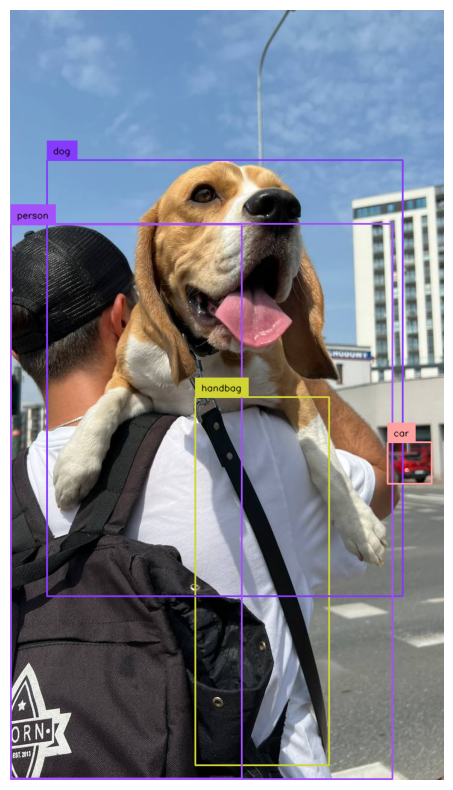

In [ ]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [2]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

workspace = rf.workspace("poultry-1")
project = workspace.project("cleanraw")
version = project.version(1)
dataset = version.download("yolov11")

mkdir: cannot create directory ‘{HOME}/datasets’: No such file or directory
[Errno 2] No such file or directory: '{HOME}/datasets'
/content


ModuleNotFoundError: No module named 'roboflow'

## Custom Training

In [1]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=19 imgsz=640 plots=True conf=0.25 patience=10

[Errno 2] No such file or directory: '{HOME}'
/content
/bin/bash: line 1: yolo: command not found


**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [47]:
!ls {HOME}/runs/detect/train6/

args.yaml					     results.png
confusion_matrix_normalized.png			     train_batch0.jpg
confusion_matrix.png				     train_batch1.jpg
events.out.tfevents.1771299107.aa4676bc834d.21942.0  train_batch2.jpg
F1_curve.png					     val_batch0_labels.jpg
labels_correlogram.jpg				     val_batch0_pred.jpg
labels.jpg					     val_batch1_labels.jpg
P_curve.png					     val_batch1_pred.jpg
PR_curve.png					     val_batch2_labels.jpg
R_curve.png					     val_batch2_pred.jpg
results.csv					     weights


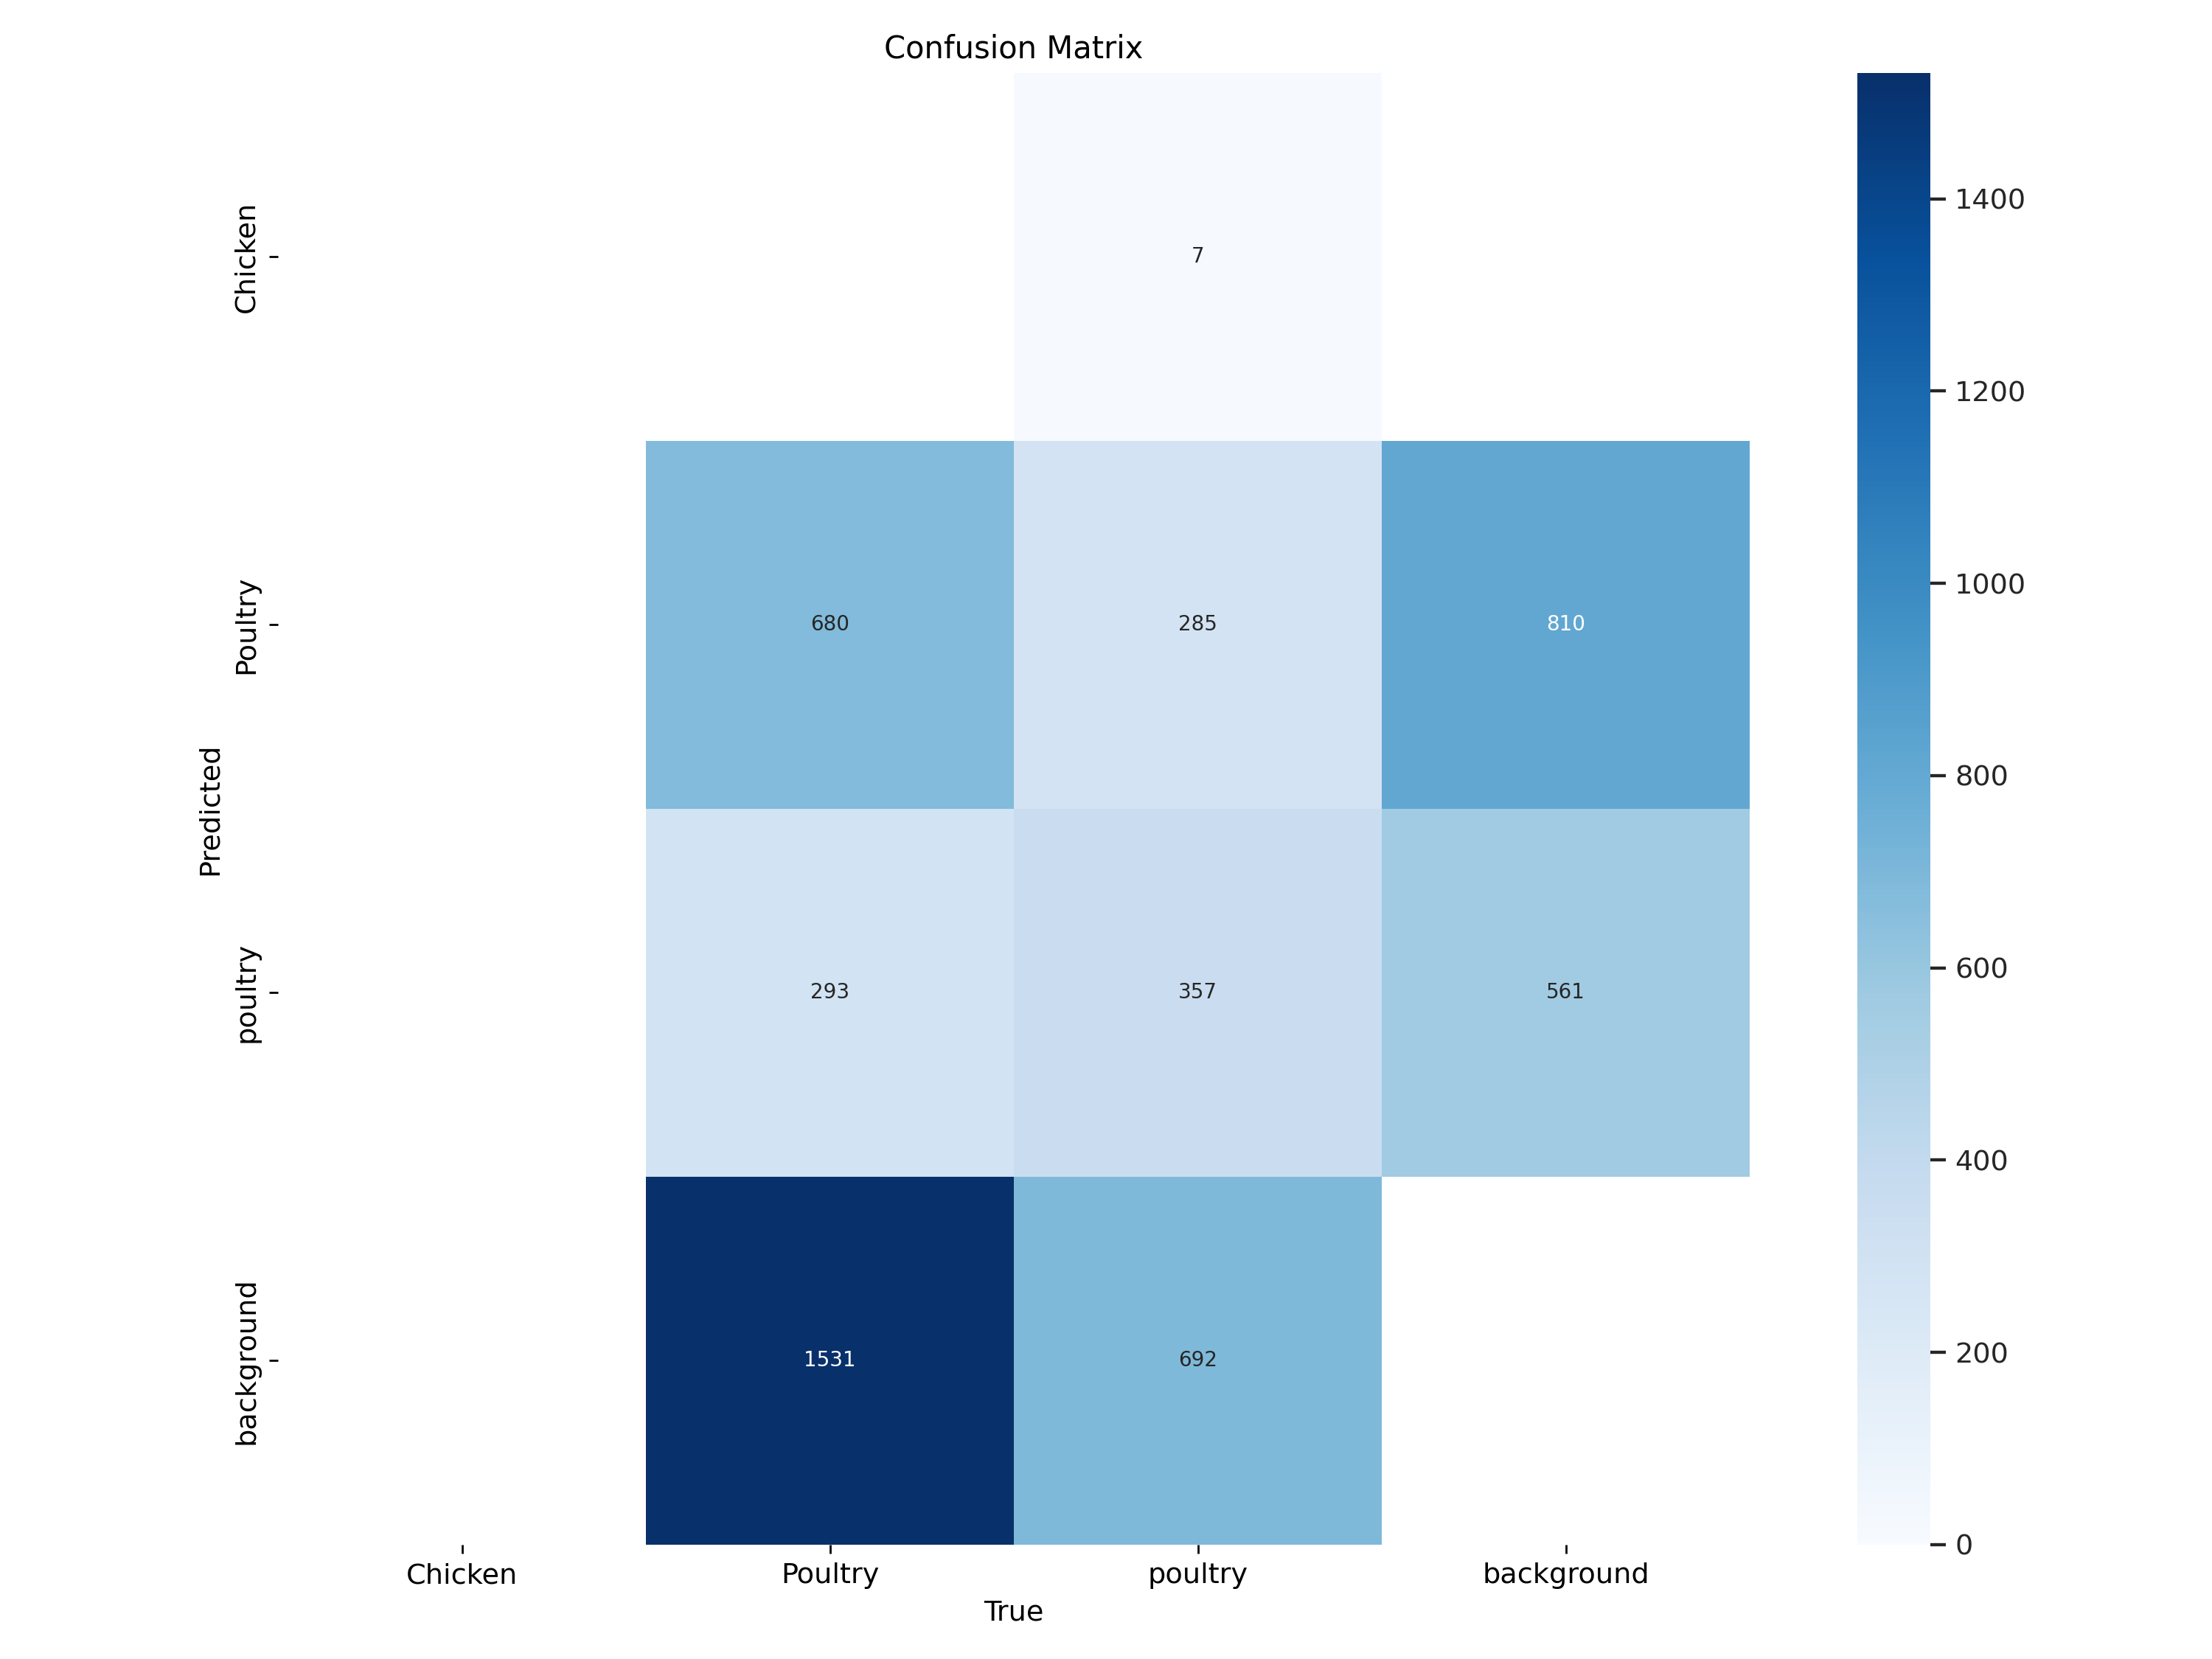

In [48]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train6/confusion_matrix.png', width=600)

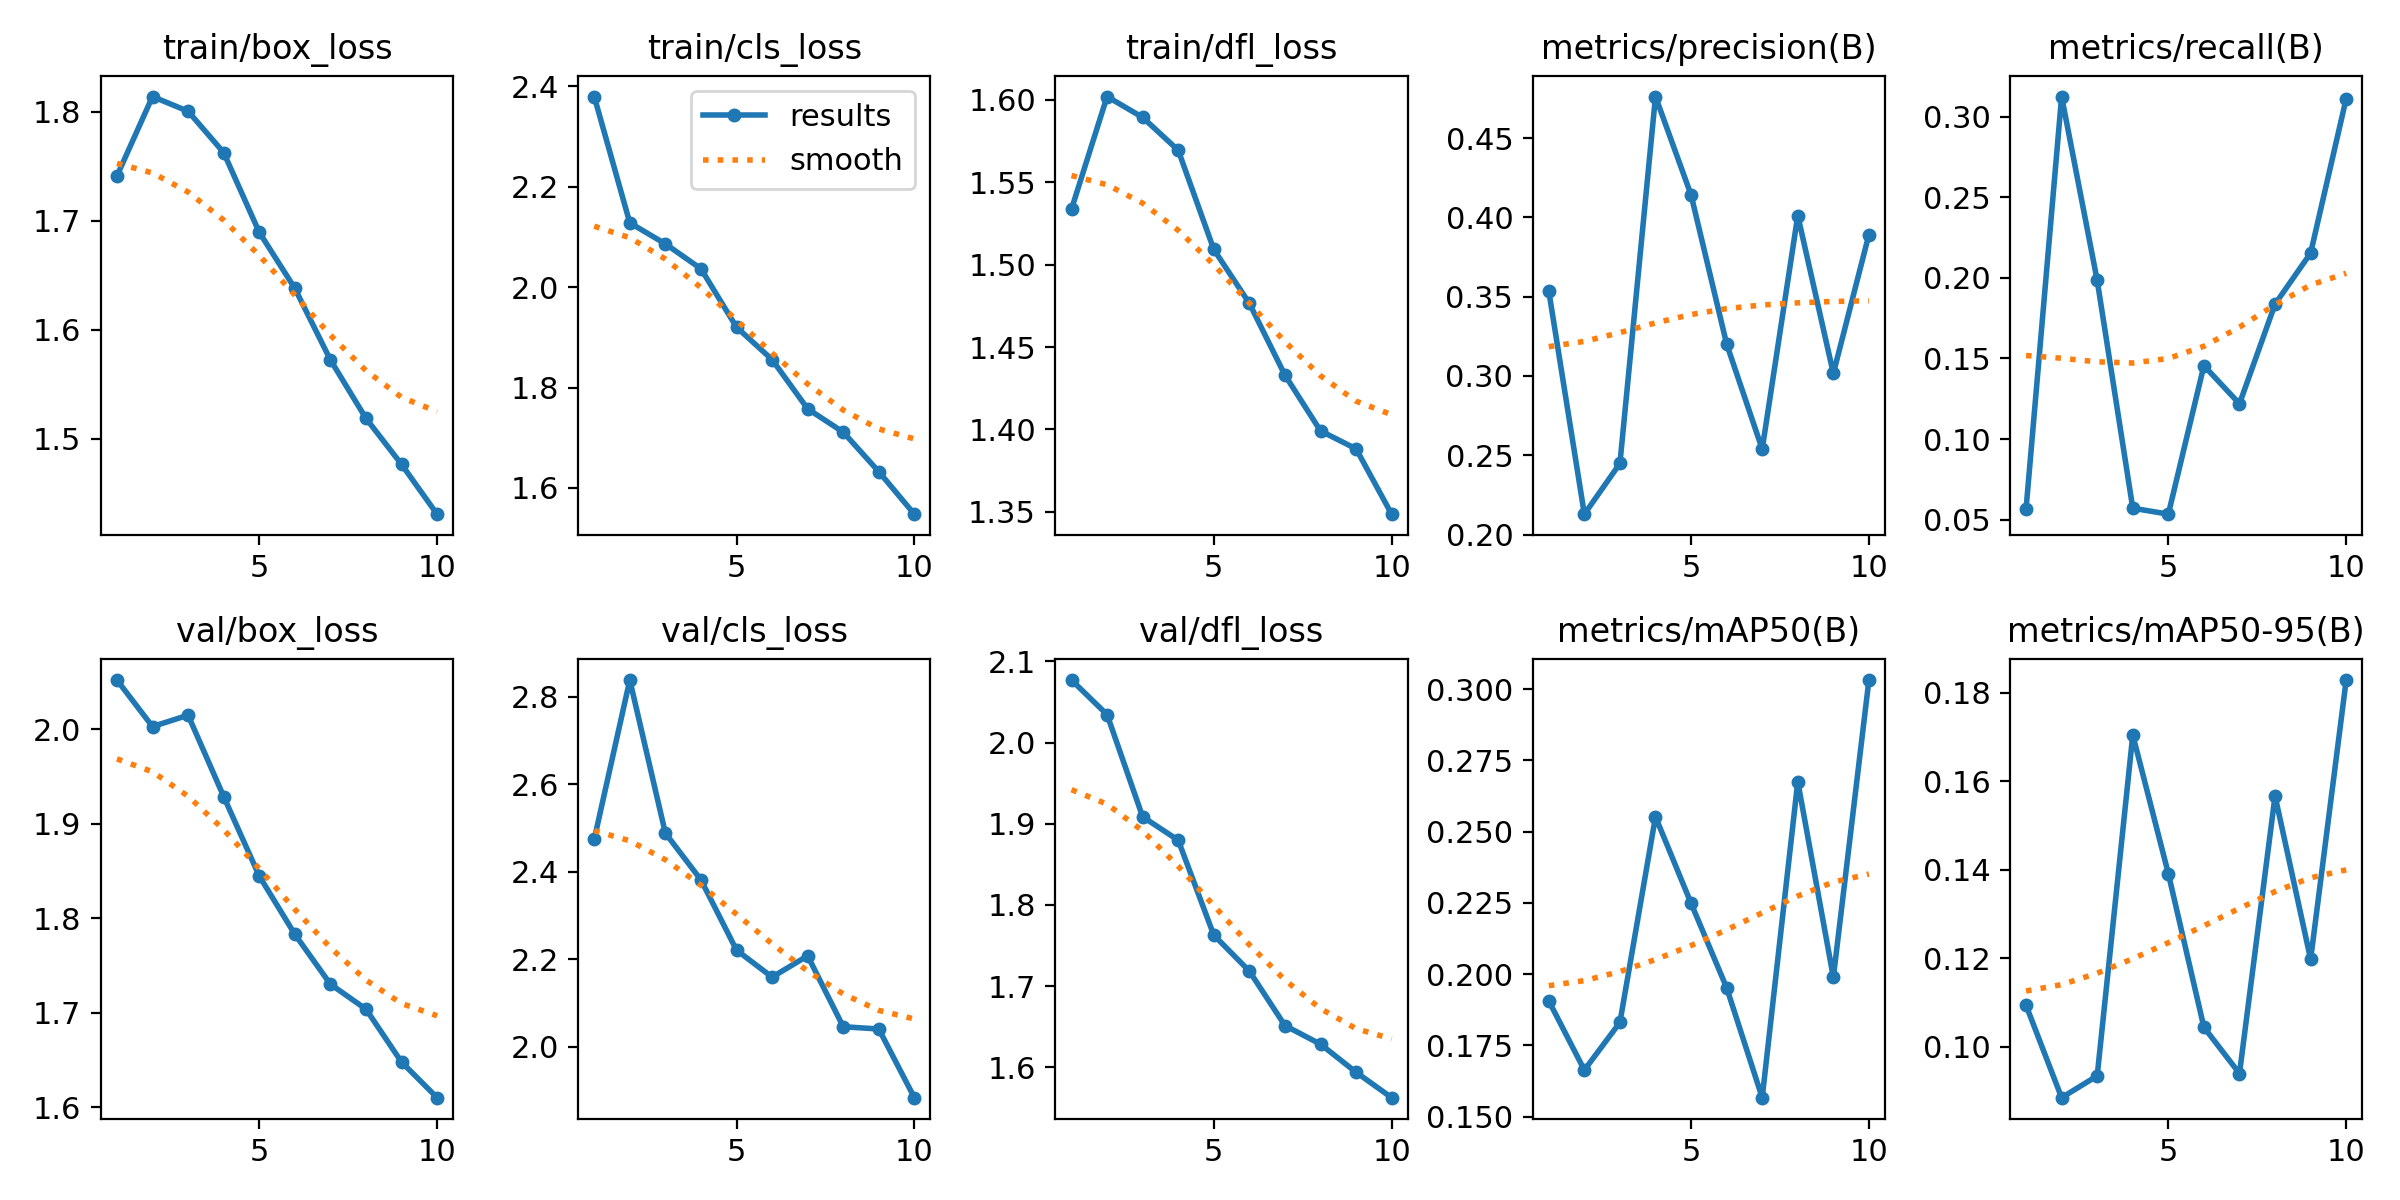

In [49]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train6/results.png', width=600)

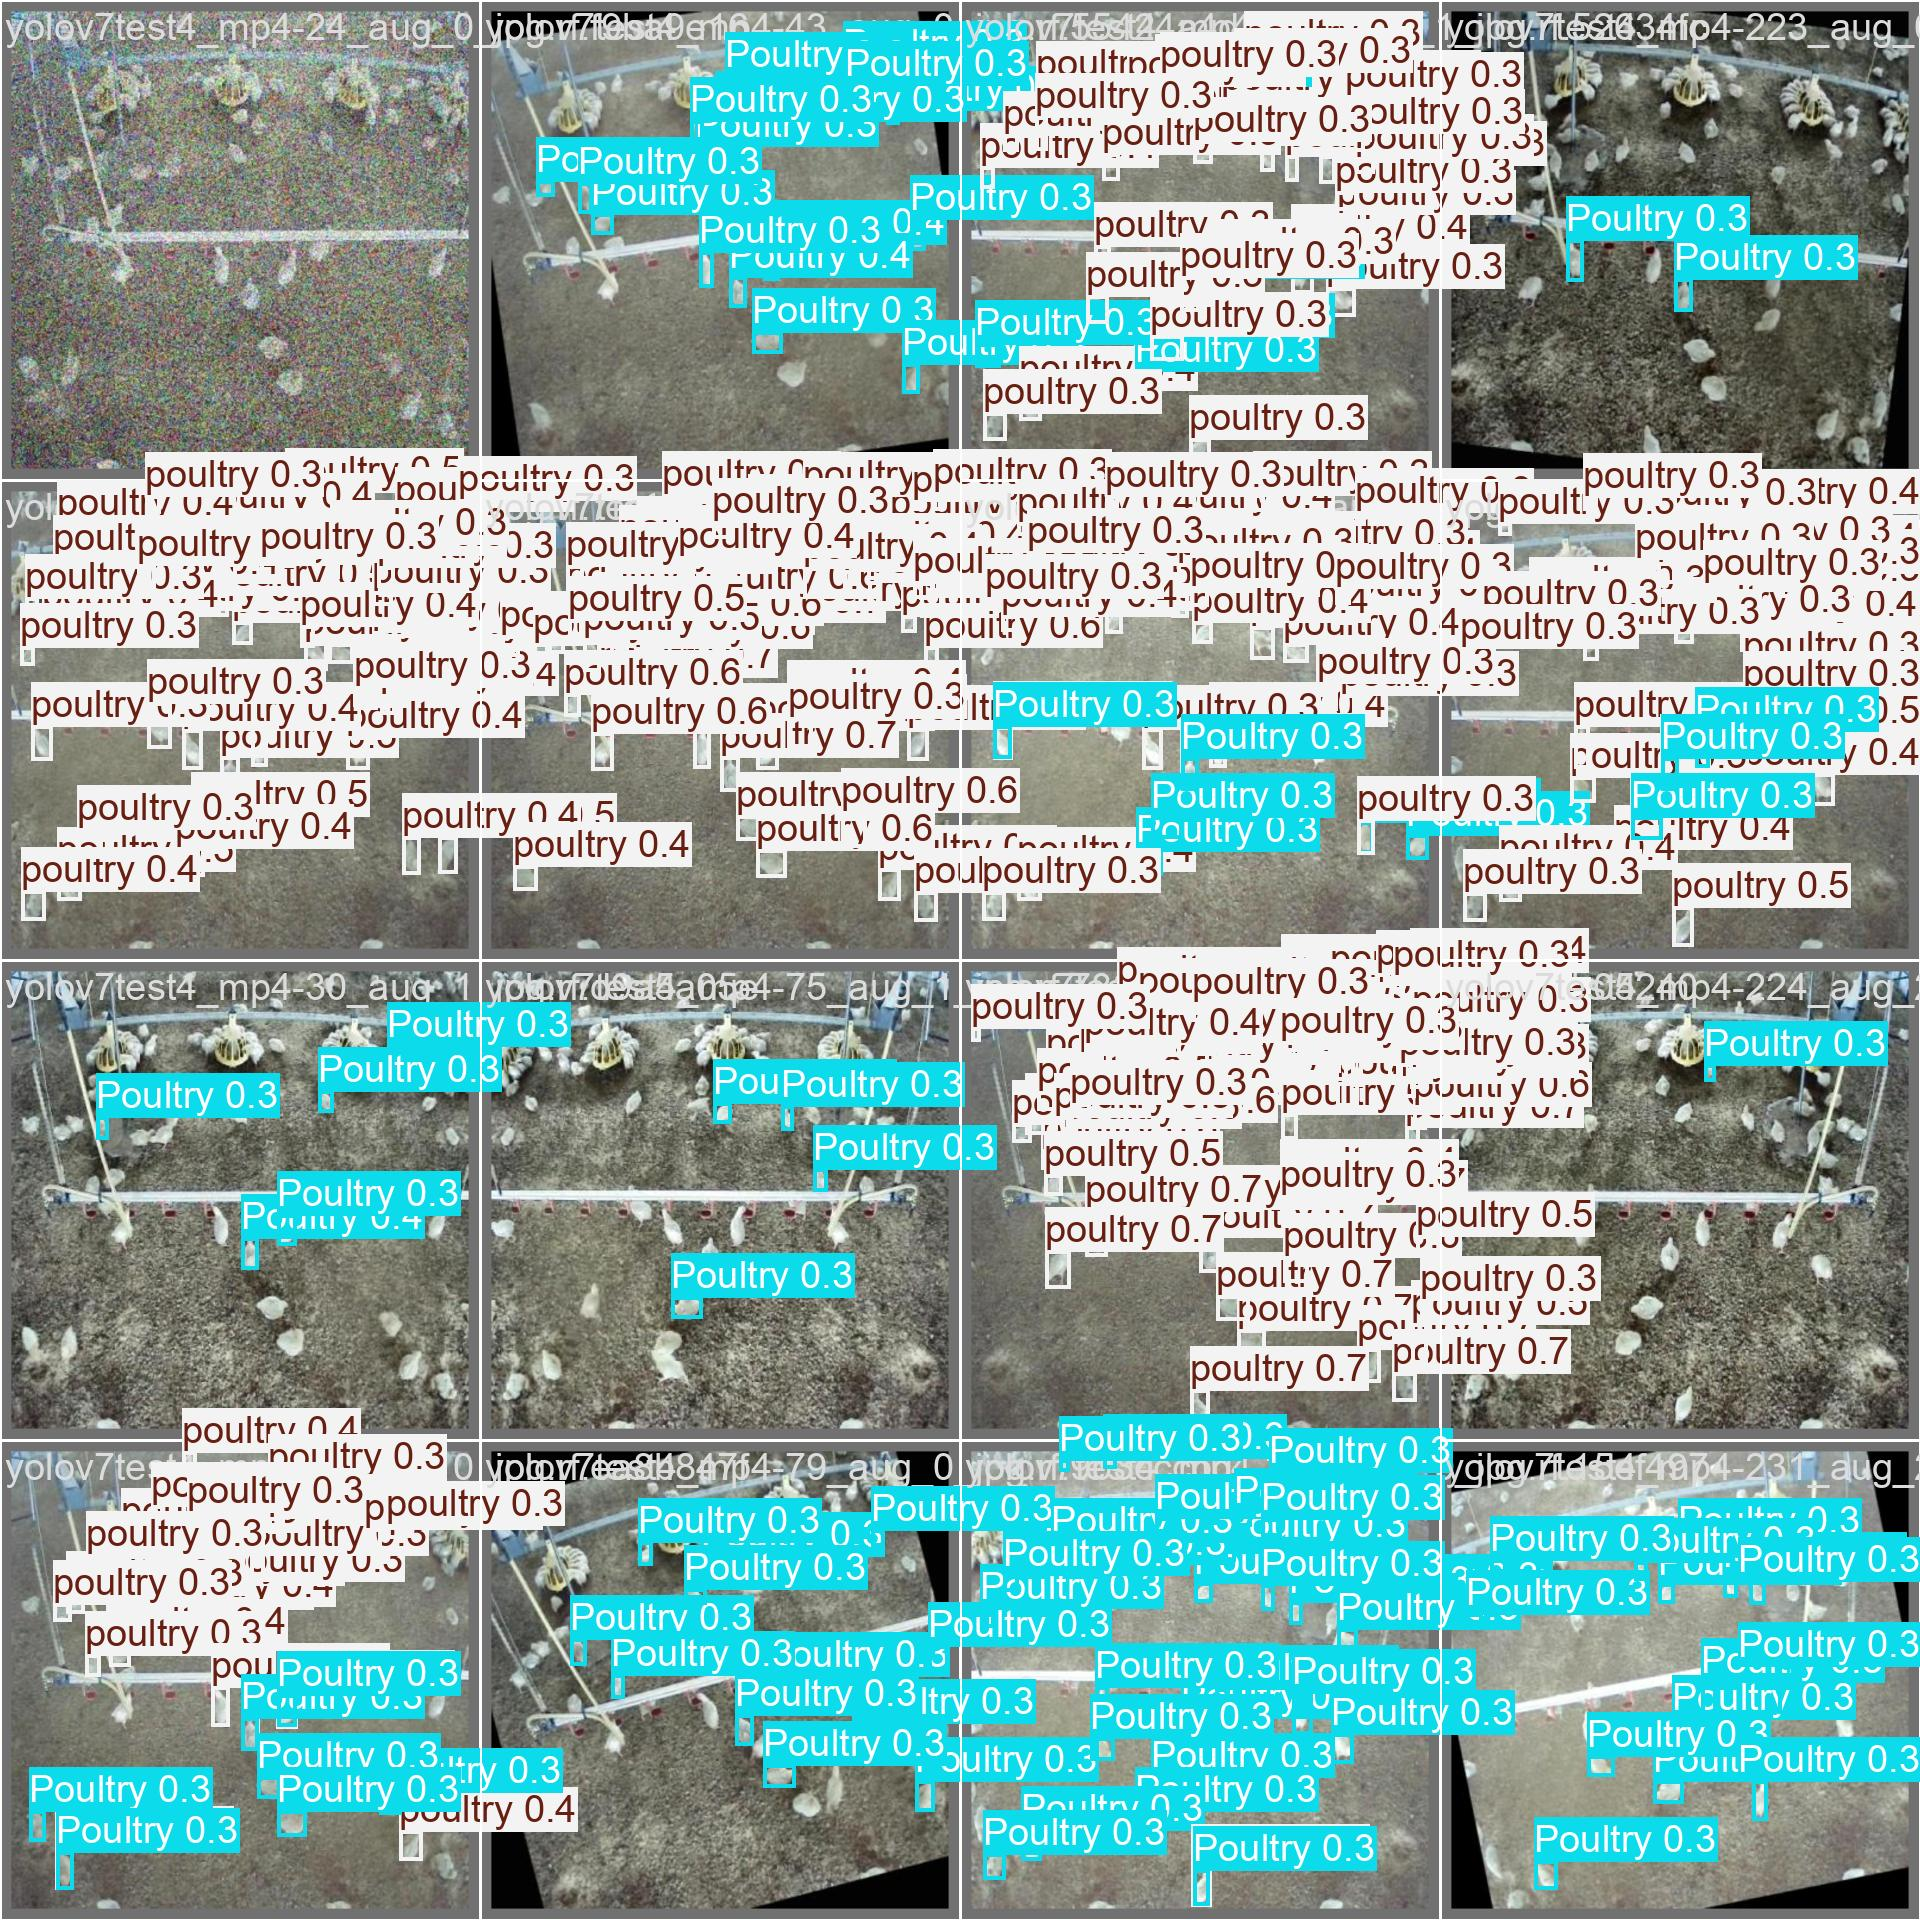

In [50]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train6/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [51]:
!yolo task=detect mode=val model={HOME}/runs/detect/train6/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
YOLO11s summary (fused): 238 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/MergedCleanRaw-1/valid/labels.cache... 290 images, 55 backgrounds, 0 corrupt: 100% 290/290 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/datasets/MergedCleanRaw-1/valid/images/216ea992e6a31289a80742dcc202800c35eae0f1_jpg.rf.c90b07d6437749b8bdcb4447abe1974a.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/MergedCleanRaw-1/valid/images/360_F_454741673_Odahhtu4oC35UvBzBVK84Qgb22X8JjlZ_aug_2_jpg.rf.7994f2e6b0f5a84adf80bd7c0a61e546.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/MergedCleanRaw-1/valid/images/IMG_20240115_115017_262_aug_1_jpg.rf.eacdc6f4e9bf48acabe9623edacb450f.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/datasets/MergedCleanRaw-1/valid/images/d93cae6a80e4892a1b7a386ebaf7cdcdfca87d9c_1_aug_1_jpg.rf.1bcc6ba0394d7eef129cfeb395d879f6.jpg: 2 

## Inference with custom model

In [52]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train6/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
YOLO11s summary (fused): 238 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs

image 1/278 /content/datasets/MergedCleanRaw-1/test/images/-_jpg.rf.d14394d32a5aa27f8dc35b7c1cb86824.jpg: 640x640 8 Poultrys, 15.6ms
image 2/278 /content/datasets/MergedCleanRaw-1/test/images/000000000406_jpg.rf.fff146aa2a46e63fed15c736fc3f521e.jpg: 640x640 6 poultrys, 15.6ms
image 3/278 /content/datasets/MergedCleanRaw-1/test/images/001_233_IMG_pri192011m-848x565_aug_0_jpg.rf.51b75d830244b97b278435449b9c6555.jpg: 640x640 2 Poultrys, 15.6ms
image 4/278 /content/datasets/MergedCleanRaw-1/test/images/001_233_IMG_pri192011m-848x565_aug_1_jpg.rf.2a4749e6fcb8698d38c10bf7299222b2.jpg: 640x640 5 Poultrys, 15.6ms
image 5/278 /content/datasets/MergedCleanRaw-1/test/images/00555716ed91967c836c1eecac51cd2e7eceac85_aug_0_jpg.rf.8ba359086872ef12563f5eadc543a928.jpg: 640x640 3 Poultrys, 4 poultrys, 15.6ms
image 6/278 /content/datasets/

**NOTE:** Let's take a look at few results.

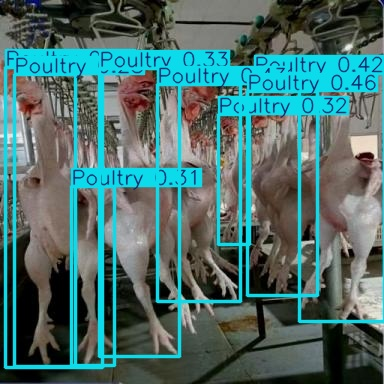

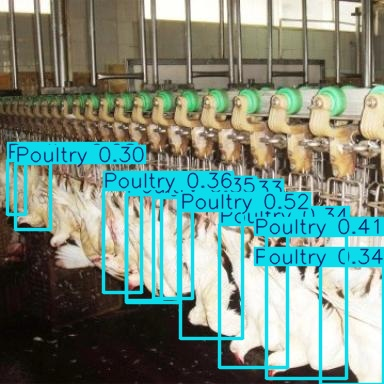

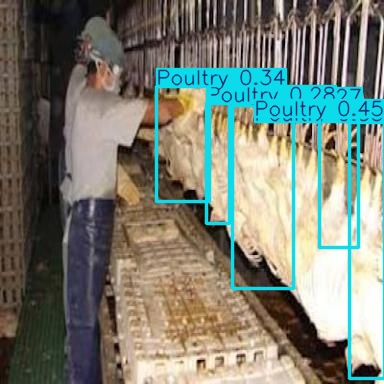

In [53]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Deploy model on Roboflow

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

In [ ]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

In [ ]:
!pip install inference

In [ ]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, userdata.get('ROBOFLOW_API_KEY'))

# Location of test set images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)


## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.